# Basic FISSA usage

This notebook explains step-by-step how to use the FISSA toolbox. See basic_usage.py for a shorter example script if one does not use a notebook interface.

In [10]:
# FISSA toolbox imports
import fissa

Plotting toolbox import. 
Plotting in this notebook is done with Holoviews, for details see http://holoviews.org/.

In [11]:
# Plotting toolbox
import holoviews as hv
%load_ext holoviews.ipython
%output widgets='embed'

The holoviews.ipython extension is already loaded. To reload it, use:
  %reload_ext holoviews.ipython


### Defining an experiment
Define your inputs. All that's necessary to define are the image data and ROIs. 

Images can be defined as a folder with tiff stacks:
```
images = 'folder'
```
Where each tiff stack in the folder is a trial with several frames.

Or the data can also be given as a list of arrays if not stored as tiffs:
```
images = [array1, array2, array3, ...]
```

For ROIs either a set of ROIs across all images should be defined, or a set of ROIs per image. 

If the ROIs were defined using ImageJ use ImageJ's export function to save them in a zip. Then, indicate the locations as a list:
```
rois = 'rois.zip' # for a single set of rois across images
rois = ['rois1.zip', 'rois2.zip',...] # for a roiset for each image
```
Defining a different roiset per image can be useful if you need to adjust for motion drift for example.

Then, we can define out experiment:

In [12]:
# roi and data locations
rois_location = 'exampleData/20150429.zip'
images_location = 'exampleData/20150529'

# Folder where data will be stored. Make sure to use a different folder for each experiment.
output_folder = 'fissa_example' 

experiment = fissa.Experiment(images_location, rois_location, output_folder)

Reloading previously prepared data...


Previously analyzed experiments in output_folder will be loaded, if they exist, and the next step could be skipped.

### Extracting traces and separating them
Next, we need to extract the traces and separate them:

In [13]:
experiment.separate()

Reloading previously prepared data...
Doing signal separation....
NMF converged after 610 iterations.
Finished ROI number 3
NMF converged after 618 iterations.
Finished ROI number 0
NMF converged after 636 iterations.
Finished ROI number 2
NMF converged after 575 iterations.
Finished ROI number 1


If you want to redo preparation and/or separation you can set:
```
experiment.separate(redo_prep=True, redo_sep=True)
```
(If you redo prepartion this will also redo the separation, to make sure these always match up).

## Accessing results
After running ```experiment.separate()``` the results are stored as follows.

#### ROI outlines
The ROI outlines, as well as the extra neuropil regions, can be found as in ```experiment.roi_polys``` as follows. For cell number ```c``` and tiff number `t`, the set of ROIs for that cell and tiff is at
```
experiment.roi_polys[c][t][0][0] # basic ROI
experiment.roi_polys[c][t][n][0] # n = 1, 2, 3.... the neuropil regions
```
Sometimes ROIs cannot be expressed as a single polygon (e.g. a ring-ROI), in those cases several polygons are used to describe it as:
```
experiment.roi_polys[c][t][0][i] # i iterates over the different polygons
```

As an example, plotting the first region of interest plus its first neuropil sub:

:Overlay
   .Curve.I  :Curve   [x]   (y)
   .Curve.II :Curve   [x]   (y)
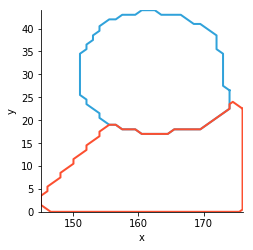

In [17]:
c = 0
t = 0
cell = hv.Curve(experiment.roi_polys[c][t][0][0])
neuropil1 = hv.Curve(experiment.roi_polys[c][t][1][0])
cell*neuropil1


#### FISSA extracted traces
The final extracted traces can be found in ```experiment.result``` as follows. For cell number ```c``` and tiff number `t`, the final extracted trace is given by:
```
experiment.result[c][t][0,:]
```

In ```experiment.result``` one can find the signals present in the cell ROI, ordered by how strongly they are present (relative to the surrounding regions). ```experiment.result[c][t][0,:]``` gives the most strongly present signal, and is seen as the cell's 'true' signal. ```[i,:]``` for ```i=1,2,3,...``` gives the other signals which are present in the cell ROI.

#### Before decontamination
The raw extracted signals can be found in ```experiment.raw``` in the same way. Now in  ```experiment.raw[c][t][i,:]```, ```i``` indicates the region number, with ```i=0``` being the cell, and ```i=1,2,3,...``` indicating the surrounding regions.

As an example, plotting the raw and extracted signals for the second trial for the third cell:

:Overlay
   .Curve.Raw            :Curve   [x]   (y)
   .Curve.Decontaminated :Curve   [x]   (y)
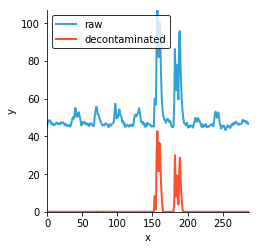

In [19]:
c = 2
t = 1
hv.Curve(experiment.raw[c][t][0,:], label='raw')*hv.Curve(experiment.result[c,t][0,:], label='decontaminated')

#### df/f0
It is often useful to calculate the df/f0 of traces. This can be done as follows. By default it is done across all trials, but it can also be done per trial by setting across_trials to False.

In [34]:
experiment.result[0][0].shape


(5, 288)

In [ ]:
experiment.calc_deltaf(freq=10, across_trials=True)

In [ ]:
c = 2
t = 1
hv.Curve(experiment.deltaf_raw[c][t], label='raw', vdims=['df/f0'])*hv.Curve(experiment.deltaf_result[c,t][0,:], label='decontaminated')

Note that this uses the F0 from the raw trace for both

## Exporting to MATLAB
The results can easily be exported to MATLAB as follows:

In [ ]:
experiment.save_to_matlab()

Loading ```output_folder/matlab.mat``` will give you three structs, ```ROIs```, ```raw```, and ```result```.
(Using the output_folder defined above)

These interface similarly as ```experiment.ROIs```, ```experiment.raw```, and ```experiment.result``` described above. However, Matlab counts from 1 (as opposed to Python counting from 0), such that the ROI, raw trace, and decontaminated trace are all found for cell 0 trial 0 as:
```
ROIs.cell0.trial0{1} % polygon for the ROI
ROIs.cell0.trial0{2} % polygon for first neuropil subregion
result.cell0.trial0(1,:) % final extracted cell signal
result.cell0.trial0(2,:) % contaminating signal
raw.cell0.trial0(1,:) % raw measured celll signal
raw.cell0.trial0(2,:) % raw signal from first neuropil subregion
```

## Sidenotes

#### Finding the tiff files
If you'd want to access a specific tifffile for a specific trial you can get its location as

In [ ]:
trial = 1
experiment.images[trial]

#### Mean image data

If you want to get the mean data of a trial you can find this in experiment.means:

In [ ]:
t=0
hv.Image(experiment.means[t])

#### FISSA settings
FISSA has several user-definable settings, which can be set during the experiment definition.

In [ ]:
# By default FISSA uses all the available processing threads. 
# This can, especially for the data preparation step, quickly fill up your memory. 
# Generally one only has to change the number of cores for the preparation steps, 
# as here it will load as many tiff stacks into memory as there are available processes.
# The number of cores for the data preparation and separation steps can be changed as:
ncores_preparation = 4 # If None, uses all available cores 
ncores_separation = None # if None, uses all available cores

# FISSA uses 4 subregions for the neuropil region, which can be set to something else
nRegions = 4

# Normally the area of each subregion is set the same as the central ROI
expansion = 1 

# The degree of signal sparsity can be controlled with the alpha parameter.
alpha = 0.1

experiment = fissa.Experiment(images_location, rois_location, output_folder,
                              nRegions=nRegions, expansion=expansion,alpha=alpha,
                              ncores_preparation=ncores_preparation, 
                              ncores_separation=ncores_separation)

Alternatively, they can also be changed post experiment definition as follows.

In [ ]:
experiment.ncores_preparation = 4
experiment.alpha = 0.1
experiment.expansion = 1

### Large tiff files
By default, FISSA loads entire tiff files at once. This can sometimes be problematic if the tiff files are too large to comfortably load into memory. To avoid this a low memory mode exists which instead loads tiff files frame by frame.

In [ ]:
experiment = fissa.Experiment(images_location, rois_location, output_folder, lowmemory_mode=True)

### Handling custom formats
By default FISSA can use tiffs or Numpy arrays for imaging data, and Numpy arrays or ImageJ ROIs for ROIs. It is also possible to give FISSA a custom script to use for other custom and/or proprietary formats that might be used by labs. In this case, one has to define a python script like fissa.datahandler (which is used internally to handle all the data). As an example, see the datahandler_custom.py script in the examples folder (where this notebook is located).

In [ ]:
import datahandler_custom

experiment = fissa.Experiment(images_location, rois_location, output_folder,
                              datahandler=datahandler_custom)